In [28]:
import numpy as np
import scipy as sp

import astropy.units as u
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

plt.style.use(['dark_background'])

# Simulating an Lenslet-based Integral Field Spectrograph

1. First define the characteristics IFS and lenslet array geometry.

In [160]:
R = 70 # spectral resolving power
f_bw = 0.18 # fractional bandpass
N_pix_per_dlam = 2
l_spec = np.ceil(N_pix_per_dlam * R * f_bw) # spectrum length
dl = 4 # adjacent spectrum seperation
interlace = 2 # spectral interlacing, number of lenslets along a row of lenslets between two neighbooring spectra
clocking_angle = np.arctan(1/interlace)
npix = 1024 # detector format
q = 13.0 * u.um
M = 1.0 # magnification
l_p = np.floor(q * (l_spec + dl)/(M * np.sqrt(interlace**2 + 1))) # lenslet pitch
n_lens = int(npix * (q/l_p)) # number of lenslets 
lam_lens = 600
print(f'Spectral Resolution: {R}')
print(f'Length of microspectrum: {l_spec}')
print(f'Clocking angle: {np.rad2deg(clocking_angle):.2f}')
print(f'Lenslet pitch: {l_p:.2f}')
print(f'Lenslet array format: {n_lens}')

Spectral Resolution: 70
Length of microspectrum: 26.0
Clocking angle: 26.57
Lenslet pitch: 174.00 um
Lenslet array format: 76


2. Initiate the integer lenslet array coordinates to be mapped to floating point pixel coordinates on the detector

In [161]:
i_lens, j_lens = np.indices((n_lens, n_lens)) - n_lens//2

3. Map the coordinates to the detector for a given wavelength using a polynomial mapping

In [162]:
def initcoef(order, scale, phi, x0=0, y0=0):
    """
    Create a set of coefficients including a rotation matrix plus zeros.
    Parameters
    ----------
    order: int
        The polynomial order of the grid distortion
    scale: float
        The linear separation in pixels of the PSFlets. Default 13.88.
    phi:   float
        The pitch angle of the lenslets.  Default atan(2)
    x0:    float
        x offset to apply to the central pixel. Default 0
    y0:    float
        y offset to apply to the central pixel. Default 0
    Returns
    -------
    coef: list of floats
        A list of length (order+1)*(order+2) to be optimized.
    Notes
    -----
    The list of coefficients has space for a polynomial fit of the
    input order (i.e., for order 3, up to terms like x**3 and x**2*y,
    but not x**3*y).  It is all zeros in the output apart from the
    rotation matrix given by scale and phi.
    """

    try:
        if not order == int(order):
            raise ValueError("Polynomial order must be integer")
        else:
            if order < 1 or order > 5:
                raise ValueError("Polynomial order must be >0, <=5")
    except BaseException:
        raise ValueError("Polynomial order must be integer")

    n = (order + 1) * (order + 2)
    coef = np.zeros((n))

    coef[0] = x0
    coef[1] = scale * np.cos(phi)
    coef[order + 1] = -scale * np.sin(phi)
    coef[n // 2] = y0
    coef[n // 2 + 1] = scale * np.sin(phi)
    coef[n // 2 + order + 1] = scale * np.cos(phi)

    return coef

In [163]:
def transform(x, y, order, coef):
    """
    Apply the coefficients given to transform the coordinates using
    a polynomial.
    Parameters
    ----------
    x:     ndarray
        Rectilinear grid
    y:     ndarray of floats
        Rectilinear grid
    order: int
        Order of the polynomial fit
    coef:  list of floats
        List of the coefficients.  Must match the length required by
        order = (order+1)*(order+2)
    Returns
    -------
    _x:    ndarray
        Transformed coordinates
    _y:    ndarray
        Transformed coordinates
    """

    try:
        if not len(coef) == (order + 1) * (order + 2):
            raise ValueError(
                "Number of coefficients incorrect for polynomial order.")
    except BaseException:
        raise AttributeError("order must be integer, coef should be a list.")

    try:
        if not order == int(order):
            raise ValueError("Polynomial order must be integer")
        else:
            if order < 1 or order > 5:
                raise ValueError("Polynomial order must be >0, <=5")
    except BaseException:
        raise ValueError("Polynomial order must be integer")

    _x = np.zeros(np.asarray(x).shape)
    _y = np.zeros(np.asarray(y).shape)

    i = 0
    for ix in range(order + 1):
        for iy in range(order - ix + 1):
            _x += coef[i] * x**ix * y**iy
            i += 1
    for ix in range(order + 1):
        for iy in range(order - ix + 1):
            _y += coef[i] * x**ix * y**iy
            i += 1

    return [_x, _y]

In [164]:
lam = 515
order = 3
scale = l_p / q 
print(scale)
dispersion = N_pix_per_dlam * R * np.log(lam / lam_lens)
coef = initcoef(order, scale, clocking_angle, npix / 2, npix/2)
coef_new = initcoef(order, scale, clocking_angle, npix / 2 +dispersion, npix/2)
x_cen, y_cen = transform(j_lens, i_lens, order=order, coef=coef)
x_cen += dispersion

13.384615384615385


In [165]:
x_cen_new, y_cen_new = transform(j_lens, i_lens, order=order, coef=coef_new)


In [166]:
np.testing.assert_array_almost_equal(x_cen,x_cen_new)

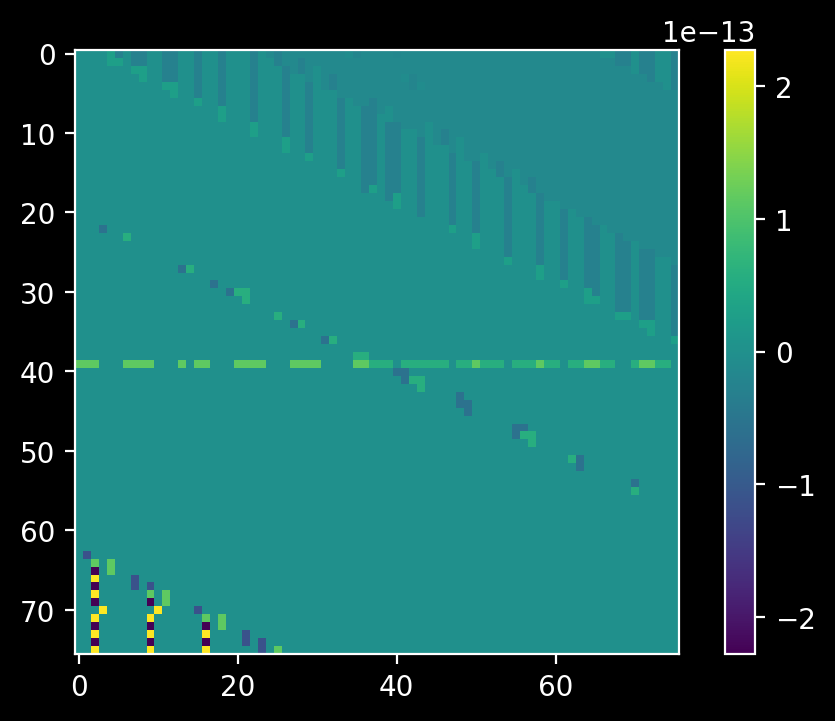

In [167]:
plt.imshow(x_cen-x_cen_new)
plt.colorbar()

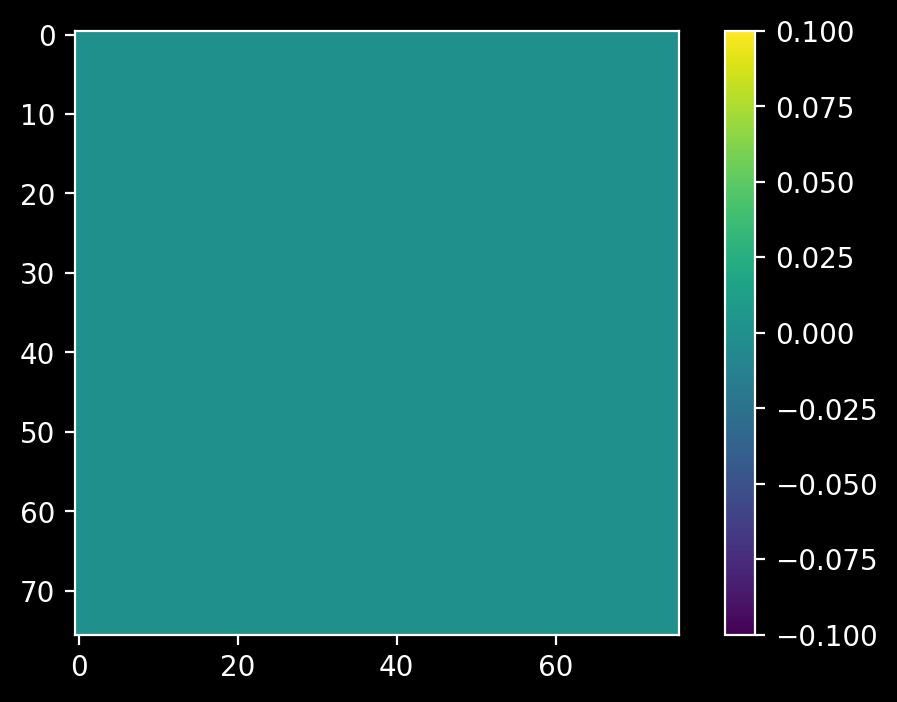

In [168]:
plt.imshow(y_cen-y_cen_new)
plt.colorbar()

In [169]:
x_cen, y_cen = transform(j_lens, i_lens, order=order, coef=coef)

transform lenslet coordinates to integer coordinates

In [170]:
x_cen, y_cen = transform(j_lens, i_lens, order=order, coef=coef)

In [171]:
x_cen

array([[ 284.54028512,  278.55450315,  272.56872118, ..., -152.42179873,
        -158.4075807 , -164.39336267],
       [ 296.51184906,  290.52606709,  284.54028512, ..., -140.45023479,
        -146.43601676, -152.42179873],
       [ 308.483413  ,  302.49763103,  296.51184906, ..., -128.47867085,
        -134.46445282, -140.45023479],
       ...,
       [1158.46445282, 1152.47867085, 1146.49288888, ...,  721.50236897,
         715.516587  ,  709.53080503],
       [1170.43601676, 1164.45023479, 1158.46445282, ...,  733.47393291,
         727.48815094,  721.50236897],
       [1182.4075807 , 1176.42179873, 1170.43601676, ...,  745.44549685,
         739.45971488,  733.47393291]])

In [172]:
y_cen

array([[-170.37914464, -158.4075807 , -146.43601676, ...,  703.54502306,
         715.516587  ,  727.48815094],
       [-164.39336267, -152.42179873, -140.45023479, ...,  709.53080503,
         721.50236897,  733.47393291],
       [-158.4075807 , -146.43601676, -134.46445282, ...,  715.516587  ,
         727.48815094,  739.45971488],
       ...,
       [ 266.58293921,  278.55450315,  290.52606709, ..., 1140.50710691,
        1152.47867085, 1164.45023479],
       [ 272.56872118,  284.54028512,  296.51184906, ..., 1146.49288888,
        1158.46445282, 1170.43601676],
       [ 278.55450315,  290.52606709,  302.49763103, ..., 1152.47867085,
        1164.45023479, 1176.42179873]])

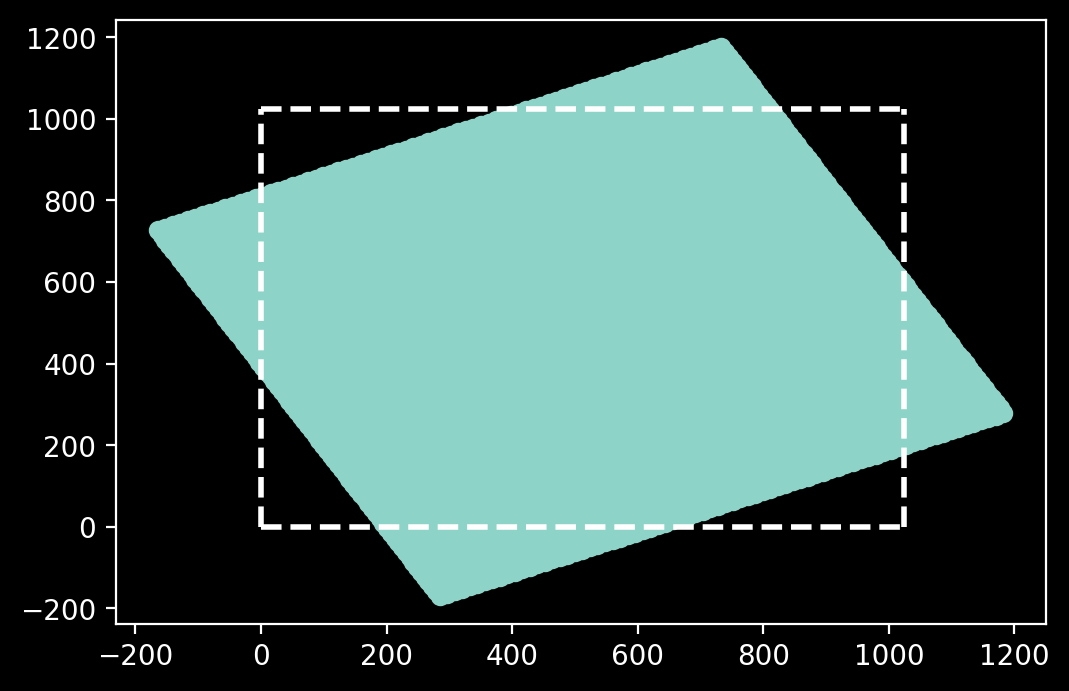

In [173]:
# plt.scatter(j_lens, i_lens)
plt.scatter(x_cen, y_cen)
plt.vlines(x=[0, npix], ymin=0, ymax=1024, colors='white', ls='--', lw=2)
plt.hlines(y=[0, npix], xmin=0, xmax=1024, colors='white', ls='--', lw=2)

In [174]:
n_spec = (l_spec + dl) * 6
print(n_spec)

180.0


In [176]:
np.sqrt((npix**2 / 180))

76.32445363199282